# Changes 11/23/2015

* Add 'center' to initial guess for red/gray/back plot
* Add missing imports numpy and pandas
* Remove seaborn
* Use gray colormap

# Figure 3

This notebook is a recipe for generating Figure 3.

## Setup

Compute profiles from video data, and define a fitting function.

In [1]:
from __future__ import division
from datetime import date
import os

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.filter
import statsmodels.api as sm
import numpy as np
from lmfit import Model, Fitter
from lmfit.models import GaussianModel
from numpy import exp, convolve
import yaml
from IPython.display import display
from pandas import Series, DataFrame
import pandas as pd

# from fetch import fetch
import pims
mpl.rcParams['image.cmap'] = 'gray'

mpl.style.use('https://gist.github.com/danielballan/be066529de85e87a5fe7/raw')

/Users/dallan/miniconda/envs/pa/lib/python3.4/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/Users/dallan/miniconda/envs/pa/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# This is just a fancy way of getting the file and the filepath from S3.
# If you have a local copy and you know where it is, you can just do:
# filename = '/path/to/file.lsm'

manifest = yaml.load(open('manifest.yml'))
trial = manifest['Fibrin'][0]  # our best trial
filename = "20140520 JCK20140519 10fold in fibrin 4mg_mL PLGA-PEG-Rhod Activation_20x 3.93sec 10 iterations 4 AU 1.lsm"
filepath = os.path.join("data", filename)
trial

{'concentration': '4 mg/ml',
 'exposure': 3930,
 'filename': '20140520 Fibrin Photoactivation/20140520 JCK20140519 10fold in fibrin 4mg_mL PLGA-PEG-Rhod Activation_20x 3.93sec 10 iterations 4 AU 1.lsm',
 'objective': '20X'}

In [3]:
v = pims.open(filepath, process_func=lambda img: img.sum(0))
v

<Frames>
Source: data/20140520 JCK20140519 10fold in fibrin 4mg_mL PLGA-PEG-Rhod Activation_20x 3.93sec 10 iterations 4 AU 1.lsm
Length: 500 frames
Frame Shape: (3, 512, 512)
Pixel Datatype: H

## Strategies for distinguishing moving particles from those stuck in the activation region

### Failed Strategy: Select the activation region and experiment with thresholding it.

This goes nowhere good.

In [4]:
fig, ax = plt.subplots()
ax.imshow(v[5])
rectangle = mpl.patches.Rectangle((0, 512//2 - 20), 511, 40, 
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=ax.transData)
ax.add_patch(rectangle)

<IPython.core.display.Javascript object>

In [5]:
activation_region = v[-1][512 // 2 - 20:512 // 2 + 20, :]
threshold = np.percentile(activation_region, 50)

fig, ax = plt.subplots()
ax.imshow(activation_region)

fig, ax = plt.subplots()
ax.imshow(activation_region > threshold)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
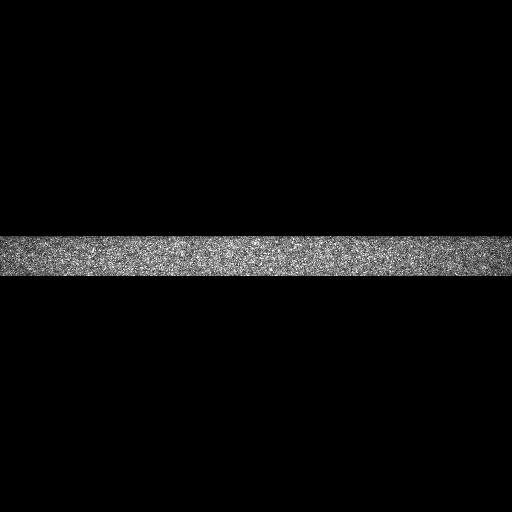

In [6]:
A = 40
L = 512
activation_slice = [slice(L // 2 - A//2, L // 2 + A//2), slice(None)]
activation_mask = np.zeros_like(v[0], dtype='bool')
activation_mask[activation_slice] = True

v[-1] * activation_mask

### Better Strategy: Subtract the last frame from all the other frames.

Many of the particles in the last frame as stuck particles. By subtracting the intesnities in the last frame from all the frames, the mobile particles remain.

Since not *all* of the particles in the last frame are stuck, this is an overcorrection. Notice in the video further below that the center region looks too dim.

Frame([[ 771,    0,    0, ...,  257,    0,  514],
       [   0, 3341, 2827, ..., 2056,    0, 1542],
       [   0,    0,    0, ...,    0,    0,    0],
       ..., 
       [ 514,    0,    0, ...,  771,    0,    0],
       [   0, 1285,    0, ..., 2570,  257,    0],
       [   0, 2570,    0, ...,    0,  514, 1285]], dtype=int16)
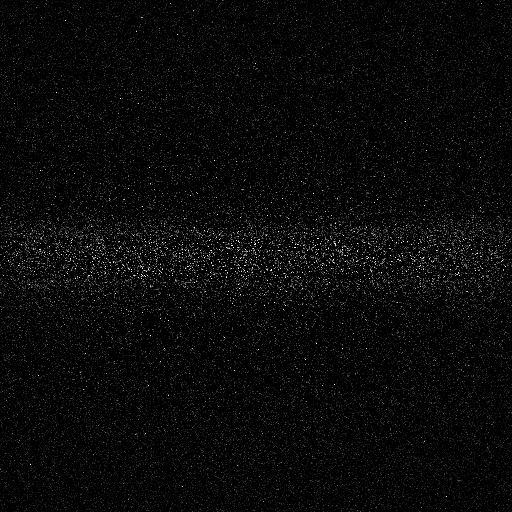

In [7]:
def subtract_frames(frame1, frame2):
    """There is some subtlety here -- you can't just frame1 - frame2 --
    but we'll contain the technical details in this function."""
    return np.clip(frame1.astype('int16') - frame2.astype('int16'), 0, None)

subtract_frames(v[10], v[-1])

In [8]:
last_frame = v[-1]
reduced_frames = [subtract_frames(frame, last_frame) for frame in v]

### Improvement: Estimate which fraction of the particles in the last frame are not actually stuck.

As diffusion proceeds, the distribution of mobile particles approaches a Gaussian. Assume that, by the time of the last frame, the distribution of the mobile particles is indeed perfectly Gaussian. The distribution stuck particles is superimposed on this.

Fit a Guassian to the tails only --- excluding the activation region, densely populated with stuck particles --- and then extrapolate that Gaussian through the activation region. The difference between the data and the Gaussian represents truly stuck particles.

With this in hand, recreate the "reduced frames" as above. But instead of subtracting the full values of the last frame, subtract values that are attenuated according to the fraction of stuck particles.

In [9]:
last_profile = Series(last_frame.sum(1))
ax = last_profile.plot(color='gray')

from lmfit.models  import ConstantModel
center = 256

model = GaussianModel(missing='drop') + ConstantModel(missing='drop')
x = np.arange(512)
# guess = model.guess(last_profile)
guess = {'sigma': 50, 'amplitude': 1e7, 'c':0.3e7, 'center': 256}
result = model.fit(last_profile, x=x, verbose=False, **guess)
h1 = result.best_values['amplitude'], result.best_values['c']
# ax.plot(result.eval(x=x), color='b')
last_profile[center - 50: center + 50] = np.nan  # exclude the activation region and more
result = model.fit(last_profile, x=x, verbose=False, **guess)
last_profile.plot(color='k', ax=ax)

full_gaussian = result.eval(x=x)  # extrapolating through center
ax.plot(full_gaussian, color='red')
# ax.set(ylim=(0, 1.6e7))
h2 = result.best_values['amplitude'], result.best_values['c']
print(h2, h1)

(1431942115.4562397, 1801766.2064570072) (996586502.08093798, 3455751.2578775468)


In [10]:

1/(1957788841.59/1924223686.02)

0.9828555792856902

In [11]:
result.best_values

{'amplitude': 1431942115.4562397,
 'c': 1801766.2064570072,
 'center': 255.99276485826348,
 'sigma': 95.690642584575627}

Frame([[   0,   11,    0, ...,    0,    0,    0],
       [ 259,    0,    0, ...,    0, 1287,    0],
       [ 249, 2819,    0, ...,    0, 1277,    0],
       ..., 
       [   0, 2810,  497, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,  763],
       [   0,    0,    0, ..., 1287,    0,    0]], dtype=int16)
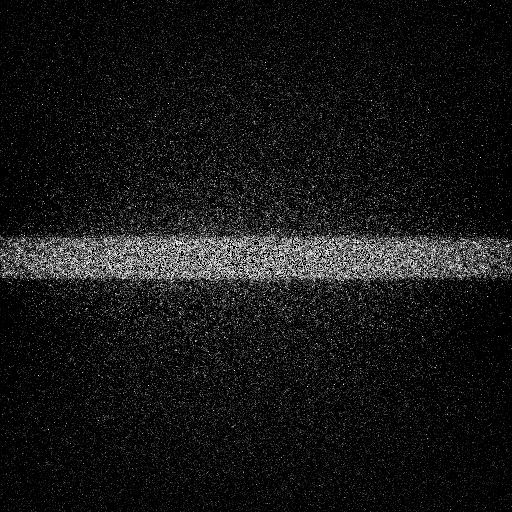

In [12]:
gaussian_as_image = np.repeat(np.expand_dims(full_gaussian / 512, 1), 512, 1).astype('uint16')
stuck_only = subtract_frames(last_frame, gaussian_as_image)

stuck_only

In [13]:
np.mean(v[-1]), np.max(v[-1]), np.min(v[-1])

(10551.189979553223, 65535, 257)

In [14]:
np.mean(gaussian_as_image), np.max(gaussian_as_image), np.min(gaussian_as_image)

(8940.197265625, 15179, 3844)

In [15]:
np.mean(stuck_only), np.max(stuck_only), np.min(stuck_only)

(2787.8852424621582, 32766, 0)

In [16]:
reduced_frames = [subtract_frames(frame, stuck_only) for frame in v]

One might worry that there could be a steep drop the intensity near the last frame, as the image begins to look more and more like the last frame. Fortunately, this is not the case. Of course, the very last frame is identically zero, but the frames leading up to it are different enough and sparse enough that the subtraction does not seriously distort them.

In [17]:
Series([frame.sum() for frame in reduced_frames]).plot()

## Analyze as we did water in Fig. 2

In [18]:
illumination_frame = 5

# Subtract out any background illumination (pre-activation).
mean_background = v[illumination_frame - 1].mean()
    
# Sum over rows (axis 1) of pixels to produce 1D profile.
# Do this for every frame from the 'illumination_frame' onward.
profiles = [frame.sum(1) - mean_background
            for frame in reduced_frames[illumination_frame:]]

# Plot an arbitrary example
plt.plot(profiles[15]);

In [19]:
class ConvolvedGaussianModel(Model):
    def __init__(self, kernel, margin=50, **kwargs):
        assert margin < len(kernel) // 2 and margin > 0, "User is a doofis."
        self.kernel = kernel
        self.margin = margin
        
        def func(x, height, sigma, center, base):
            # Note: This uses kernel, defined just above.
            gaussian = base + height * exp(-(x-center)**2/(2*sigma**2))
            result = convolve(gaussian, self.kernel, 'same')
            return result[self.margin:-self.margin]
        
        super(ConvolvedGaussianModel, self).__init__(func, **kwargs)
        
    def guess_starting_values(self, profile):
        self.set_param_hint('height', value=1, min=0)
        self.set_param_hint('sigma' , value=len(profile) / 2 - np.argmax(profile - profile.min() > profile.ptp() / 2),
                            min=0, max=1000)
        self.set_param_hint('center', value=len(profile) / 2, min=0, max=len(profile))
        self.set_param_hint('base', value=0, min=0)
        self.has_initial_guess = True
    
    def fit(self, profile, **kwargs):
        # TODO Justify margin=50 once I understand what the word convolution means.
        profile = profile.copy()
        m = self.margin  # for brevity
        x = np.arange(m, 512 - m)

        if not self.param_hints:
            self.guess_starting_values(profile[m:-m])
            
        fit_result = super(ConvolvedGaussianModel, self).fit(profile[m:-m], x=x, **kwargs)

        return fit_result
    

def fit_line(x, y):
    """Return slope, intercept of best fit line."""
    # intercept is forced to zero
    model = sm.OLS(y, x, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    return fit

## Some Intermediate Steps

Use a least-squared best fit to determine the Gaussian (with width $\sigma$) that, when convolved with Frame X, becomes similar to Frame X + 10.

In [20]:
lag = 10

fit_result = None
profile_nos = range(lag, len(profiles))  #  lag, lag + 1, lag + 2, ...
sigma = Series(index=profile_nos)

for i in profile_nos:
    # Define our kernel and build a Model from it.
    kernel = profiles[i - lag].copy()
    kernel_min = kernel.min()
    kernel -= kernel_min
    cg_model = ConvolvedGaussianModel(kernel)
    
    # If this is not our first iteration, use the best fit from the last
    # point as our initial guess for this point.
    if fit_result:
        for name, p in fit_result.params.items():
            cg_model.set_param_hint(name, value=p.value)
            
    calibration = manifest['Calibrations'][trial['objective']]/len(profiles[0])  # microns per pixel
    
    # Fit and record result
    profile = profiles[i]
    fit_result = cg_model.fit(profile)
    sigma.loc[i] = fit_result.values['sigma'] * calibration

In [21]:
sigma.dropna().tail()

490    1.582011
491    0.553870
492    1.398504
493    0.592910
494    3.156530
dtype: float64

In [22]:
ax = sigma[sigma < 100].plot(style='.')
ax.set(ylabel=r'$\sigma$ [\textmu m]', xlabel='ending frame');
ax.set(ylim=(0,5))

[(0, 5)]

In [23]:
plt.figure()
plt.plot(profiles[0])

<IPython.core.display.Javascript object>

In [24]:
profiles[0].mean()

2007154.8649978638

Ideally, all of the points above measure diffusion over 10 frames, and they should all give the same value for $\sigma$. The random variation is noise; the trend through early frames is attributed to occlusion; the fall-off at late frames for reasons unknown. Below, we will extract a representative value for discarding the final few points and taking the median of the remaining points.

But first compute the same thing for intervals $t$=20, 40, 60, ... 280. Below is the same code as above, put into a function.

In [25]:
def sigmas_at_lagtime(profiles, lag):
    fit_result = None
    profile_nos = range(lag, len(profiles))  #  lag, lag + 1, lag + 2, ...
    sigma = Series(index=profile_nos)

    for i in profile_nos:
        # Define our kernel and build a Model from it.
        kernel = profiles[i - lag]
        kernel_min = kernel.min()
        kernel -= kernel_min
        cg_model = ConvolvedGaussianModel(kernel)

        # If this is not our first iteration, use the best fit from the last
        # point as our initial guess for this point.
        if fit_result:
            for name, p in fit_result.params.items():
                cg_model.set_param_hint(name, value=p.value, min=p.min, max=p.max)

        calibration = manifest['Calibrations'][trial['objective']]/len(profiles[0])  # microns per pixel

        # Fit and record result
        profile = profiles[i]
        fit_result = cg_model.fit(profile)
        sigma.loc[i] = fit_result.values['sigma'] * calibration
    return sigma

In [26]:
sigmas = [sigmas_at_lagtime(profiles, lag) for lag in np.arange(20, 501, step=20)]

Show many data series like the one above on one set of axes. Distinguish different intervals (20, 40, 60...) by color.

In [27]:
fig, ax = plt.subplots()

for i, s in enumerate(sigmas):
    s = s.iloc[:500]
    ax.plot(s.index, s, '.', label=20*(i + 1))
    
ax.set(xlabel='ending frame', ylabel=r'$\sigma$ [\textmu m]')
# ax.legend(loc='best', title='lag interval', fontsize=12)
ax.set(title=r'Full Ensemble of $\sigma$ for a Given Interval')

<IPython.core.display.Javascript object>

In [28]:
#DataFrame(sigmas).T.to_excel('sigmas spaced by 20.xlsx')

Get a representative $\sigma$ for each interval (color). Take the median of the first 5 points. This is suspect, but it's a start.

In [29]:
representative_sigma = Series([s.iloc[15:].mean() for s in sigmas], index=np.arange(20, 501, step=20))
#representative_sigma.to_frame().to_excel('representative sigma.xlsx')

In [31]:
ax = representative_sigma.plot(style='o')

ax.set(xlim=(0, None))
ax.set(xlabel='frame interval', ylabel=r'$\sigma$ [\textmu m]')
ax.set(title=r'Representative $\sigma$ (median)')

IndexError: index 0 is out of bounds for axis 0 with size 0

That looks vaguely square-root like. What about $\sigma^4$?

<IPython.core.display.Javascript object>


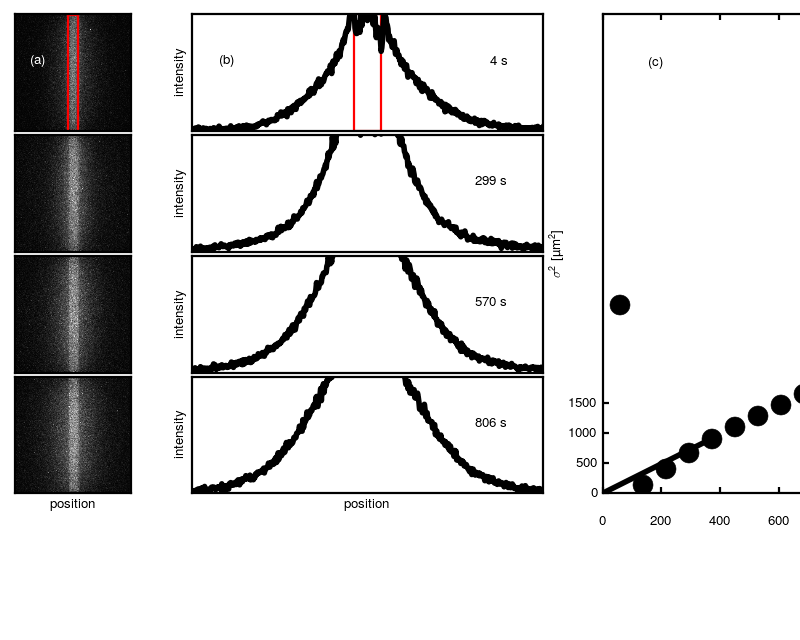

2.45340801154


In [32]:
fps = 1/3.93
s = representative_sigma
t = (s.index - illumination_frame)/fps
fig, ax = plt.subplots()
ax.plot(t, representative_sigma**2, 'o')

ax.set(xlim=(0, None))
ax.set(xlabel='time [s]', ylabel=r'$\sigma^2$ [\textmu m$^2$]')

ols_result = fit_line(t[:-4], s.iloc[:-4]**2)
slope = ols_result.params['x1']
ax.plot(t, slope*t, '--')
print(slope)

The higher points don't fit on a line. Maybe $\sigma(t)$ is exponential....

In [33]:
ax = (representative_sigma).plot(style='o', logx=True)

ax.set(xlim=(0, None))
ax.set(xlabel='log frame interval', ylabel=r'$\sigma$ [\textmu m]')

[<matplotlib.text.Text at 0x1057da5f8>, <matplotlib.text.Text at 0x1057f50b8>]

Fit a line to the points and compute $D$ using $2a$ = 160 nm and $\eta_{\text{water}}$ = 1.002 (at 68 F = 20 C).

## Draw the Final Figure

In [34]:
fps = 1000/trial['exposure']

# Construct a grid of subplots.
grid = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 3, 2, 2])
image_axes = list(map(plt.subplot, [grid[i, 0] for i in range(4)]))
profile_axes= list(map(plt.subplot, [grid[i, 1] for i in range(4)]))
plot_ax = plt.subplot(grid[:, 2:])

# Configure axes labels / ticks.
[ax.set(xticks=[], yticks=[]) for ax in image_axes]
[ax.set(xticks=[], yticks=[], ylabel='intensity') for ax in profile_axes]
profile_axes[-1].set(xlabel='position')
image_axes[-1].set(xlabel='position')
plot_ax.set(xlabel=r'$t$ [s]', ylabel=r'$\sigma^2$ [\textmu m$^2$]')

# Draw in the frames of video.
frame_nos = [6, 81, 150, 210]  # Ben chose [6, 81, 196, 387] but I'm missing 387 -- fix later!
for ax, frame_no in zip(image_axes, frame_nos):
    image = v[frame_no]
    # flip diagonally
    image = image.T
    ax.imshow(image)

# plot_ax.imshow()

# Draw in the profiles.
for ax, frame_no in zip(profile_axes, frame_nos):
    ax.plot(profiles[frame_no - illumination_frame], 'k')
    ax.set(ylim=(0, 5e6))
    # Label the time
    t = int(round((frame_no - illumination_frame)/fps, 0))
    ax.text(0.9, 0.6, '{0} s'.format(t), ha='right', va='center', transform=ax.transAxes)
    
# Outline the activation region.
rectangle1 = mpl.patches.Rectangle((512//2 - 20, 0), 40, 511,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=image_axes[0].transData)
rectangle2 = mpl.patches.Rectangle((512//2 - 20, 0), 40, 5e6,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=profile_axes[0].transData)
image_axes[0].add_patch(rectangle1)
profile_axes[0].add_patch(rectangle2)
    
# Draw in the sigma vs. t data.
t = (s.index - illumination_frame)/fps
x = np.array([0, 370])
plot_ax.plot
plot_ax.plot(t, s**2, 'ko')
plot_ax.plot(x, slope * x, 'k-')
plot_ax.set(yticks=[0, 500, 1000, 1500])

# Label (a), (b), (c).
image_axes[0].text(0.2, 0.6, '(a)', ha='center', va='center', transform=image_axes[0].transAxes, color='white')
profile_axes[0].text(0.1, 0.6, '(b)', ha='center', va='center', transform=profile_axes[0].transAxes)
plot_ax.text(0.1, 0.9, '(c)', ha='center', va='center', transform=plot_ax.transAxes)

# Tweak subplot spacing.
plot_ax.figure.set_size_inches(14.5, 7)
grid.tight_layout(plot_ax.figure, h_pad=0.3, w_pad=0.5)


Caption: Photactivatable nanoparticles diffuse in water. (a) The region outlined in red, which is 34 microns wide, is momentarily exposed to UV laser light, and any particles within that region become fluorescent. (b) Their subsequent diffusion is characterized by an intensity profile representing the summed intensity of each individual column in the image. Profiles at different times can be mapped onto each other through convolution with a Gaussian, as described in the text. (c) The Gaussian that maps a given profile at any $t'$ onto the profile at $t' + t$ has width $\sigma(t)$. This is related to the nanoparticles' diffusivity $D$ through $\sigma^2 = 2Dt$. We extract the value $D$=2.45 μm$^2$/s, which is compatibile with the theoretical diffusivity of 160-nm particles in water at room temperature.

In [35]:
first_illuminated_frame = illumination_frame
exposure_time = trial['exposure']
lag_times = (s.index - illumination_frame)/fps

In [41]:
msd = pd.read_csv('fibrin-imsds.csv').iloc[:-5]
msd_lt = 0.05 * np.arange(1, len(msd) + 1)

In [40]:
@pims.pipeline
def convert_to_gray(img):
    return np.rot90(np.sum(img, 0))

mottled_video_filename = 'data/20140401 4mg_ml fibrin JCK20140325 PLGA-PEG-Rhod Activation_40x 1.57sec 3.lsm'
mottled_video = convert_to_gray(pims.TiffStack(mottled_video_filename))
mottled_img = mottled_video[-1]

<IPython.core.display.Javascript object>


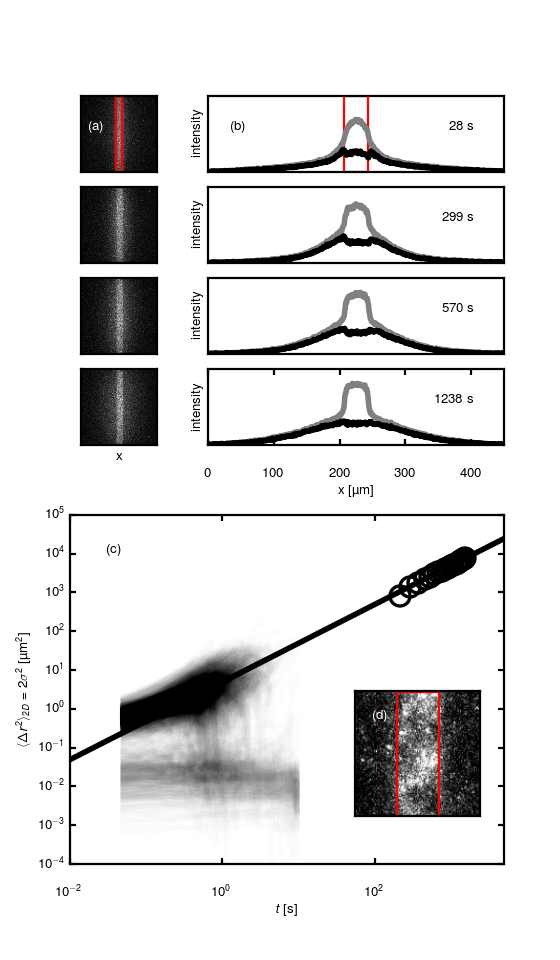

In [45]:
fig = plt.figure(figsize=(7, 12))

# Construct a grid of subplots.
big_grid = mpl.gridspec.GridSpec(2, 1)
grid = mpl.gridspec.GridSpecFromSubplotSpec(4, 2, width_ratios=[1, 3], height_ratios=[1, 1, 1, 1], subplot_spec=big_grid[0, 0])
image_axes = [plt.subplot(grid[0, 0])]
image_axes.extend([plt.subplot(grid[i, 0]) for i in range(1, 4)])
profile_axes = [plt.subplot(grid[0, 1])]
profile_axes.extend([plt.subplot(grid[i, 1]) for i in range(1, 4)])
plot_ax = plt.subplot(big_grid[1, 0])

# Configure axes labels / ticks.
[ax.set(xticks=[], yticks=[]) for ax in image_axes]
[ax.set(yticks=[], ylabel='intensity') for ax in profile_axes]
[ax.set(xticks=[]) for ax in profile_axes[:-1]]
profile_axes[-1].set(xlabel=r'x [\textmu m]')
image_axes[-1].set(xlabel='x')
plot_ax.set(xlabel=r'$t$ [s]', ylabel=r'$\langle \Delta r^2 \rangle_{2D} = 2 \sigma^2$ [\textmu m$^2$]')

# Draw in the frames of video.
frame_nos = [12, 81, 150, 320]
for ax, frame_no in zip(image_axes, frame_nos):
    image = v[frame_no]
    # flip diagonally
    image = image.T
    ax.imshow(image)

# Draw in the profiles.
PROFILE_WINDOW_HEIGHT = 2e7
profile_x = np.arange(512) * calibration
for ax, frame_no in zip(profile_axes, frame_nos):
    ax.plot(profile_x, v[frame_no].sum(1) - v[frame_no].sum(1).min(), 'gray')
    ax.plot(profile_x, profiles[frame_no - first_illuminated_frame], 'k')
    ax.set(ylim=(0, PROFILE_WINDOW_HEIGHT))
    # Label the time
    t = int(round((frame_no - first_illuminated_frame) * exposure_time/1000, 0))
    ax.text(0.9, 0.6, '{0} s'.format(t), ha='right', va='center', transform=ax.transAxes)
    plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set(xticks=[0, 100, 200, 300, 400])
    
# Outline the activation region.
rectangle1 = mpl.patches.Rectangle((512//2 - 20, 0), 40, 511,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=image_axes[0].transData)
rectangle2 = mpl.patches.Rectangle((calibration * 512//2 - calibration * 20, 0), calibration * 40, PROFILE_WINDOW_HEIGHT,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=profile_axes[0].transData)
image_axes[0].add_patch(rectangle1)
profile_axes[0].add_patch(rectangle2)

def prepend_zero(arr):
    return np.append(arr, [0], 0)

# Draw inset.
inset_ax = plt.axes([.57, .15, .35, .13])
inset_ax.imshow(mottled_img[512//2 - 60:512//2 + 60, 512//2 - 60:512//2 + 60])
inset_ax.set(xticks=[], yticks=[])
rectangle3 = mpl.patches.Rectangle((60 - 20, 0), 40, 120,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=inset_ax.transData)
inset_ax.add_patch(rectangle3)

# fit line (to sigma)
x_ = np.array([1e-2, 5e3])
plot_ax.plot(x_, 2 * slope*x_, color='k')
# MDS
plot_ax.plot(msd_lt, msd, color='black', alpha=0.01)
# sigma data
plot_ax.plot(lag_times[2:-5], 2 * representative_sigma[2:-5]**2, marker='o', mec='black', mew=3, c='none')
plot_ax.set(xscale='log', yscale='log')
plot_ax.set(xticks=[1e-2, 1, 1e2], xlim=[1e-2, 5e3]) #, yticks=[1e-2, 1, 1e2], ylim=[1e-2, 5e4])
plot_ax.tick_params(axis='both', which='major')
plot_ax.minorticks_off()
plot_ax.set(ylim=(1e-4, 1e5))

# plot_ax.set(yticks=np.arange(0, 5000, 1000))


# Label (a), (b), (c).
image_axes[0].text(0.2, 0.6, '(a)', ha='center', va='center', transform=image_axes[0].transAxes, color='white')
profile_axes[0].text(0.1, 0.6, '(b)', ha='center', va='center', transform=profile_axes[0].transAxes)
plot_ax.text(0.1, 0.9, '(c)', ha='center', va='center', transform=plot_ax.transAxes)
inset_ax.text(0.2, 0.8, '(d)', ha='center', va='center', transform=inset_ax.transAxes, color='white')

In [ ]:
len(v) / fps